In [38]:

import io
import os
import time
import datetime
import json
import shutil
import numpy as np
import pandas as pd
# import folium # draw route on map
from folium import plugins
import datetime
from datetime import timedelta
from pathlib import Path
from scipy.io import arff
import folium  # draw route on map
from folium import plugins
from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go
%matplotlib inline

import torch
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS,  DBSCAN, Birch 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

from ts2vec import TS2Vec
import datautils
from tasks import _eval_protocols as eval_protocols

print(np.__version__)
print(pd.__version__)
print(torch.__version__)
!python3 --version

dir_training = Path('training')

1.19.2
1.3.3
1.8.1+cu111
Python 3.8.10


## load pretrained model

In [40]:
n_feature = 6
# Train a TS2Vec model
model = TS2Vec(
    input_dims=n_feature,
    device='cuda',
    output_dims=320
)
model_path = 'training/dora_b16_320d/model_500.pkl'
model.load(model_path)

## Load embedding 

In [41]:
train_array = np.load(f'datasets/DORA/dora.npz',)['sensor'].astype(np.float64)
mean = np.nanmean(train_array)
std = np.nanstd(train_array)
train_array = (train_array - mean) / std

# # Compute instance-level representations for dataset
embedding  = model.encode(train_array, encoding_window='full_series')  # n_instances x output_dims
embedding.shape

(7972, 320)

In [42]:
# ck = f'b16_320d_ck500'
# save_path = Path('embedding')

# embedding = np.load(save_path/f'embedding_{ck}.npz',)['embedding']
# print(f'{save_path}/embedding_{ck}.npz loaded')
# print(embedding.shape)

### load train , test data

In [7]:
train_data, train_labels, test_data, test_labels = datautils.load_DORA_KA51AG8742('dora_KA51AG8742')

mean = np.nanmean(train_data)
std = np.nanstd(train_data)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

In [8]:
# # Compute instance-level representations for dataset
train_repr = model.encode(train_data, encoding_window='full_series')  # n_instances x output_dims
test_repr = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims
print(train_repr.shape, test_repr.shape)

(2313, 320) (992, 320)


## fit classification model

In [9]:

eval_protocol = 'linear'

if eval_protocol == 'linear':
    fit_clf = eval_protocols.fit_lr
elif eval_protocol == 'svm':
    fit_clf = eval_protocols.fit_svm
elif eval_protocol == 'knn':
    fit_clf = eval_protocols.fit_knn

In [10]:
def merge_dim01(array):
    return array.reshape(array.shape[0]*array.shape[1], *array.shape[2:])

if train_labels.ndim == 2:
    train_repr = merge_dim01(train_repr)
    train_labels = merge_dim01(train_labels)
    test_repr = merge_dim01(test_repr)
    test_labels = merge_dim01(test_labels)

In [11]:
clf = fit_clf(train_repr, train_labels)
acc = clf.score(test_repr, test_labels)

test_labels_onehot = label_binarize(test_labels, classes=np.arange(train_labels.max()+1))

if eval_protocol == 'linear':
    y_score = clf.predict_proba(test_repr)  # probability of label : [0, 1]
    auprc = average_precision_score(test_labels_onehot, y_score[:, 1])
else:
    y_score = clf.decision_function(test_repr)
    auprc = average_precision_score(test_labels_onehot, y_score)

print('acc : ', acc)
print('auprc : ',auprc)


acc :  0.657258064516129
auprc :  0.35526617266141397


In [12]:
pred_test = clf.predict(test_repr)
pred_label0 =  1- (np.count_nonzero(pred_test) / len(test_labels))
ground_label0 =  1- (np.count_nonzero(test_labels) / len(test_labels))
print(f'pred of test Label 0 : {pred_label0 }') 
print(f'Truth of test Label 0 : {ground_label0}') 
 


pred of test Label 0 : 0.8326612903225806
Truth of test Label 0 : 0.6955645161290323


992


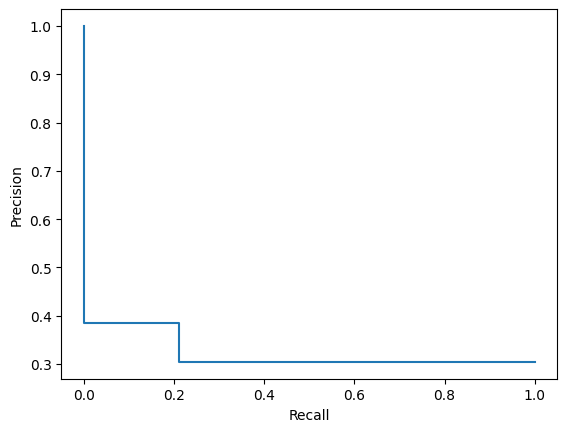

In [13]:
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)
test_pred = clf.predict(test_repr)
print(len(test_pred))
precision, recall, _ = precision_recall_curve(test_labels, test_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall )
disp.plot();

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       690
           1       0.39      0.21      0.27       302

    accuracy                           0.66       992
   macro avg       0.55      0.53      0.52       992
weighted avg       0.61      0.66      0.62       992



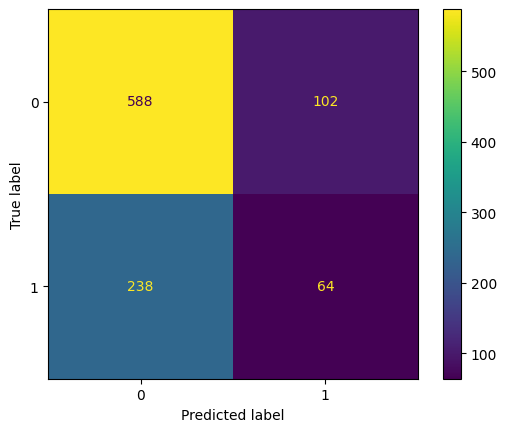

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
print(classification_report(y_true=test_labels, y_pred=test_pred))

cm = confusion_matrix(y_true=test_labels, y_pred=test_pred)
ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot();

--- 

## label by predictions

In [40]:

pred_prob  = clf.predict_proba(embedding)[:, 1]
threshold = 0.8
prediction_all = np.where(pred_prob > threshold, 1, 0 ) 
n_abnormal = np.count_nonzero(prediction_all)
print(f'Number of abnormal : {n_abnormal}({100*n_abnormal/len(prediction_all):5.2f}%) ')
 

Number of abnormal : 257( 3.22%) 


In [30]:
ck = f'b16_320d_ck500'
save_path = Path('embedding')
file_umap_2d = f'umap2d200n_embedding_{ck}'
# file_umap_3d = f'umap3d200n_embedding_{ck}'

print(file_umap_2d, )

# print(file_umap_3d )

umap_embed = np.load(save_path/f'{file_umap_2d}.npz',)['embedding']
print(umap_embed.shape)

umap2d200n_embedding_b16_320d_ck500
(7972, 2)


- def plot_scatter2d_c()

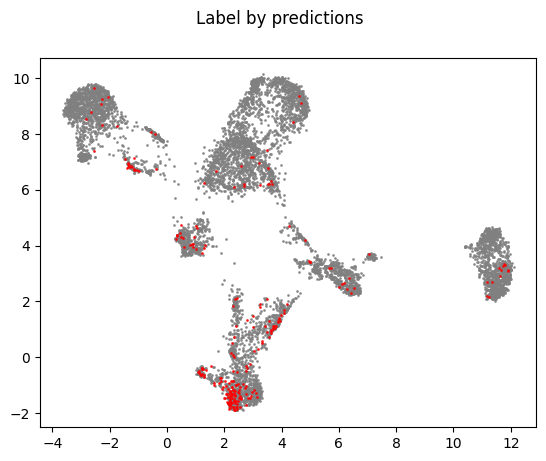

In [41]:
idx_abnormal = prediction_all == 1
labels = prediction_all
save_plot = Path('plot/umap')
title =  f'Label by predictions'
# title += f'abnormal'
save_path = save_plot/f'{title}.png'
s=1
alpha=0.8

fig, ax = plt.subplots()

scatter = ax.scatter(umap_embed[~idx_abnormal,0], umap_embed[~idx_abnormal,1], 
            c='grey',  s=s, alpha=alpha, 
            # edgecolors='black', lw=.03
            )

scatter = ax.scatter(umap_embed[idx_abnormal,0], umap_embed[idx_abnormal,1], 
            c='red',  s=s, alpha=alpha, 
            # edgecolors='black', lw=.03
            )
# plt.colorbar(scatter)
fig.suptitle(title)
fig.savefig(save_path, bbox_inches='tight')

# plot_scatter2d_c(umap_embed, labels=labels, title=title , save_path=save_path)

In [ ]:
df_pLabel =  pd.DataFrame(prediction_all, columns=['PseudoLabel'])
                     
path_ = 'datasets/DORA/pseudoLabel.csv'
df_pLabel.to_csv(path_)

df_pLabel = pd.read_csv(path_, index_col=0)
df_pLabel

,PseudoLabel
0,0
1,0
2,0
3,0
4,0
...,...
7967,1
7968,1
7969,0
7970,0


### sample profile of abnormal label 

In [ ]:
file = 'datasets/DORA/dora_meta.csv'
meta = pd.read_csv(file , index_col=0)
meta['timestamp_conv'] = meta['timestamp_conv'].astype('datetime64[s]')
meta.drop(['timestamp', 'gsen_timeTick', 'gyro_timeTick'], axis=1, inplace=True)
meta_vehicle_id  = meta.groupby(['vehicle_id', 'event_id']).id.count().reset_index().drop(['id'], axis=1)
meta_vehicle_id

,vehicle_id,event_id
0,KA01AF2992,1
1,KA01AF2992,2
2,KA01AF2992,3
3,KA01AF2992,4
4,KA01AF2992,7
...,...,...
7967,MH04KF8187,1093
7968,MH04KF8187,1094
7969,MH04KF8187,1095
7970,MH04KF8187,1096


In [ ]:
file = 'datasets/DORA/dora_meta.csv'
meta = pd.read_csv(file , index_col=0)
meta['timestamp_conv'] = meta['timestamp_conv'].astype('datetime64[s]')
meta.drop(['timestamp', 'gsen_timeTick', 'gyro_timeTick'], axis=1, inplace=True)
meta_vehicle_id  = meta.groupby(['vehicle_id', 'event_id']).id.count().reset_index().drop(['id'], axis=1)

meta_vehicle_id = meta_vehicle_id.merge(df_pLabel, left_index=True, right_index=True) 

meta_vehicle_id

,vehicle_id,event_id,PseudoLabel
0,KA01AF2992,1,0
1,KA01AF2992,2,0
2,KA01AF2992,3,0
3,KA01AF2992,4,0
4,KA01AF2992,7,0
...,...,...,...
7967,MH04KF8187,1093,1
7968,MH04KF8187,1094,1
7969,MH04KF8187,1095,0
7970,MH04KF8187,1096,0


In [ ]:
n = meta_vehicle_id.groupby(['vehicle_id']).event_id.count()
n_abnormal =  meta_vehicle_id.groupby(['vehicle_id']).PseudoLabel.sum()
# n_abnormal['abnalmal_P'] = n_abnormal/n
pd.DataFrame(n_abnormal/n, columns=['P_Abnormal'])

,P_Abnormal
vehicle_id,
KA01AF2992,0.268116
KA01AF482,0.119828
KA04MW6569,0.256477
KA51AG8742,0.246479
MH04KF8187,0.201507


In [ ]:
abnormal = meta_vehicle_id.query('PseudoLabel==1')
abnormal

,vehicle_id,event_id,PseudoLabel
31,KA01AF2992,35,1
34,KA01AF2992,38,1
35,KA01AF2992,39,1
40,KA01AF2992,44,1
66,KA01AF2992,70,1
...,...,...,...
7924,MH04KF8187,1050,1
7939,MH04KF8187,1065,1
7942,MH04KF8187,1068,1
7948,MH04KF8187,1074,1


In [ ]:
path_plot = Path(f'plot/pseudoLabel')
if not path_plot.exists():
    path_plot.mkdir(exist_ok=True, parents=True)

temp = meta.reset_index()

for tuple_ in abnormal.itertuples():
    idx, v_model_, event_id_, _ =  tuple_
    
    dir_src = Path(f'plot/{v_model_}')
    dir_dst = path_plot
     
    print(f'Vehicle : {v_model_}, event : {event_id_}', end='\r') 
    file_ = f'{v_model_}_event{event_id_}'
    profile_file_ = file_ + '.png'
    map_file_ = file_ + '_map.png'
    
    src = dir_src/profile_file_ 
    src_map = dir_src/map_file_ 
    
    dst = dir_dst/profile_file_ 
    dst_map = dir_dst/map_file_ 

    try:
        if src.exists():
            shutil.copyfile(src, dst)
        if src_map.exists():
            shutil.copyfile(src_map, dst_map)
    except:
        print(f'{src_map} not found')
